<a href="https://colab.research.google.com/github/adnan119/Fashion-mnist-GANs/blob/main/fashion_mnist_GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Creating a Basic Generative Adversarial Network to generate new fashion-mnist images**

# **What are GANs?**

Generative Adversarial Networks were first introduced by Goodfellow et al. in their 2014 paper, Generative Adversarial Networks. These networks can be used to generate **synthetic (i.e. fake)** images that are perceptually near identical to their ground-truth authentic originals.

GAN architecture consisits of two neural networks:

1. A generator that accepts an input vector of randomly generated noise 
and tries to produces an output “imitation” image that looks similar, if not identical, to the authentic image.

2. A discriminator or adversary, is a clssifier that takes as input real images as well as fake images from the generator and learns to classify them as real or fake. 


There's two-way training of generator as well as discriminator that continues to go on where generator network's goal is to fool the discriminator by generating fake images that looks as real as the real ones, and discriminator's goal is to distinguish between real & fake images with highest possible accuracy.

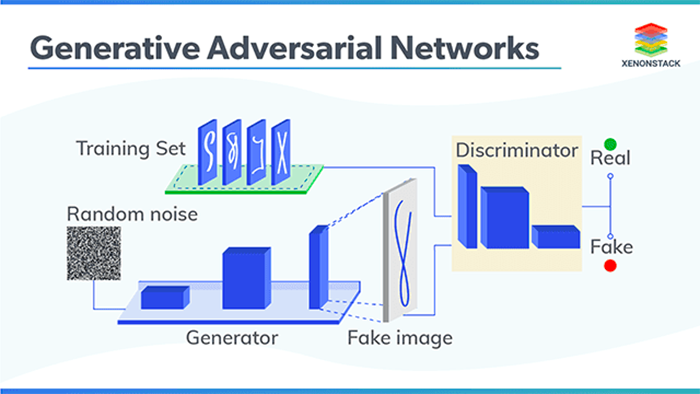

## **Implementing the Generator Network**

The generator of our GAN will accept an N dimensional input vector (i.e., a list of numbers) and then transform the N dimensional vector into an output image.

This process implies that we need to reshape and then upscale this vector into a volume as it passes through the network — to accomplish this reshaping and upscaling, we’ll need transposed convolution.

## **Implementing the Discriminator Network**

The Discriminator network is nothing but a simple binary classifier whose role is to classify whether a given image is *real* or *fake*.

The Input to this network will be real images from our dataset of fashion-mnist images & the sythetic images generated from the Generator netwrok.

In [1]:
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose #<-- transposed convolution for upsampling
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import fashion_mnist
from tensorflow import stop_gradient
from tensorflow import one_hot
from sklearn.utils import shuffle
from imutils import build_montages
import numpy as np
import argparse
import cv2
import os

In [2]:
class DCGAN:
	@staticmethod
	def build_generator(dim, depth, channels=1, inputDim=100,
		outputDim=512):
		# initialize the model along with the input shape to be
		# "channels last" and the channels dimension itself
		model = Sequential()
		inputShape = (dim, dim, depth)
		chanDim = -1

    # first set of FC => RELU => BN layers
		model.add(Dense(input_dim=inputDim, units=outputDim))
		model.add(Activation("relu"))
		model.add(BatchNormalization()) # <-- batch normalization layers will be used to reduce internal covariate shift
  
		# second set of FC => RELU => BN layers, this time preparing
		# the number of FC nodes to be reshaped into a volume
		model.add(Dense(dim * dim * depth))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
  
    # reshape the output of the previous layer set, upsample +
		# apply a transposed convolution, RELU, and BN
		model.add(Reshape(inputShape))
		model.add(Conv2DTranspose(32, (5, 5), strides=(2, 2),
			padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
  
    # apply another upsample and transposed convolution, but
		# this time output the TANH activation
		model.add(Conv2DTranspose(channels, (5, 5), strides=(2, 2),
			padding="same"))
		model.add(Activation("tanh"))
		# return the generator model
		return model

	@staticmethod
	def build_discriminator(width, height, depth, alpha=0.2):
		# initialize the model along with the input shape to be
		# "channels last"
		model = Sequential()
		inputShape = (height, width, depth)
		# first set of CONV => RELU layers
		model.add(Conv2D(32, (5, 5), padding="same", strides=(2, 2),
			input_shape=inputShape))
		model.add(LeakyReLU(alpha=alpha))
		# second set of CONV => RELU layers
		model.add(Conv2D(64, (5, 5), padding="same", strides=(2, 2)))
		model.add(LeakyReLU(alpha=alpha))
		# first (and only) set of FC => RELU layers
		model.add(Flatten())
		model.add(Dense(512))
		model.add(LeakyReLU(alpha=alpha))
		# sigmoid layer outputting a single value
		model.add(Dense(1))
		model.add(Activation("sigmoid"))
		# return the discriminator model
		return model

## **Generator Architecture**

First, our model will accept an input vector that is 100-d, then transform it to a 512-d vector via an FC
layer.

We then add a second FC
layer, this one with 7x7x64 = 3,136 nodes. We reshape these 3,136 nodes into a 3D volume with shape 7×7x64 — this reshaping is only possible since our previous FC
layer matches the number of nodes in the reshaped volume.

**Applying a transposed convolution with a 2×2 stride increases our spatial dimensions from 7×7 to 14×14.**

A second transposed convolution (again, with a stride of 2×2) increases our spatial dimension resolution from 14×14 to 28×18 with a single channel, which is the exact dimensions of our input images in the Fashion MNIST dataset.

When implementing your own GANs, make sure the spatial dimensions of the output volume match the spatial dimensions of your input images. Use transposed convolution to increase the spatial dimensions of the volumes in the generator.

In [3]:
#initializing the generator
model = DCGAN()
generator = model.build_generator(7,64)
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               51712     
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              1608768   
_________________________________________________________________
activation_1 (Activation)    (None, 3136)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3136)              12544     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0

## **Discriminator Architecture**
As we can see, this network is simple and straightforward. We first learn 32, 5×5 filters, followed by a second CONV
layer, this one learning a total of 64, 5×5 filters. We only have a single FC
layer here, this one with 512
nodes.

All activation layers utilize a Leaky ReLU activation to stabilize training, except for the final activation function which is sigmoid. We use a sigmoid here to capture the probability of whether the input image is real or synthetic.

In [ ]:
#initializing the discriminator
discriminator = model.build_discriminator(28,28,1)
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 32)        832       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          51264     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1606144   
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)              

## Visulizing synthetic images from the GANs

In [ ]:
from numpy import zeros
from numpy.random import randn
from matplotlib import pyplot

def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
  # generate points in latent space
  x_input = generate_latent_points(latent_dim, n_samples)
  # predict outputs
  X = g_model.predict(x_input)
  images = ((X * 127.5) + 127.5).astype("uint8")
  images = np.repeat(images, 3, axis=-1)
  # create 'fake' class labels (0)
  y = zeros((n_samples, 1))
  return X, y
 

## **Training Procedure**

To begin training our GAN architecture we first define our model using TensorFLow's Model fucntion.

1. The way we define this architecture is by first freezing the paprameters of the descrimintor.
2. Then we begin by passing the desired input shape to the generator.
3. We pass this output of the generator to the discriminator to get a classification score. It's this final score on which our generator acrhiteture will be trained.
4. Then we use *ADAM* as the optimizer and *binary cross entropy* as our loss fucntion to compile this model. 

### Training loop

Training a GAN architecture isn't about minimizing any loss fucntion  rather it's about finidng a perfect equilibrium between the generator and the discriminator of the architecture, and the way do this is by:

1. Creating a shuffled batch of real as well as synthetic images generated by the generator with every iteration of the loop.
2. This batch of shuffled images is then used to train the discriminator, where the real images are labeled as '1' and the fake ones as '0'.
3. Then the training of the generator takes place where we generate a batch of fake images using random noise. These fake images are then sent ot the discriminator for classification but this time we switch the labels for fake images from '0' to '1'. Doing this allows us to evaluate how close the fake generated images are from the real ones.
4. The loss from the output of above step is then used to train the generator.

In [ ]:
#initializing a few hyper-parameters
NUM_EPOCHS = 50
BATCH_SIZE = 128
INIT_LR = 2e-4

In [ ]:
# load the Fashion MNIST dataset and stack the training and testing
# data points so we have additional training data

((trainX, _), (testX, _)) = fashion_mnist.load_data()
trainImages = np.concatenate([trainX, testX])
# add in an extra dimension for the channel and scale the images
# into the range [-1, 1] (which is the range of the tanh
# function)
trainImages = np.expand_dims(trainImages, axis=-1)
trainImages = (trainImages.astype("float") - 127.5) / 127.5

4423680/4422102 [==============================] - 0s 0us/step


Note that while loading the dataset we aren't using any test set since our goal when training a GAN isn’t minimal loss or high accuracy. Instead, we seek an equilibrium between the generator and the discriminator.

In [ ]:
#initializing the discriminator optimizer & loss function
discOpt = Adam(lr=INIT_LR, beta_1=0.5, decay=INIT_LR / NUM_EPOCHS)
discriminator.compile(loss="binary_crossentropy", optimizer=discOpt)

In [ ]:
# build the adversarial model by first setting the discriminator to
# *not* be trainable, then combine the generator and discriminator
# together
print("[INFO] building GAN...")
discriminator.trainable = False
ganInput = Input(shape=(100,))
ganOutput = discriminator(generator(ganInput))
gan = Model(ganInput, ganOutput)
# compile the GAN
ganOpt = Adam(lr=INIT_LR, beta_1=0.5, decay=INIT_LR / NUM_EPOCHS)
gan.compile(loss="binary_crossentropy", optimizer=discOpt)

[INFO] building GAN...


### **Training Loop**

[INFO] starting training...
[INFO] starting epoch 1 of 50...
[INFO] Step 1_545: discriminator_loss=0.555281, adversarial_loss=1.176732


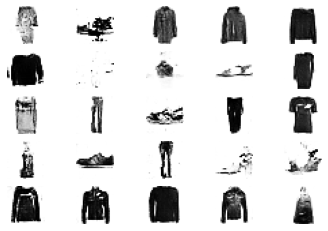

[INFO] starting epoch 2 of 50...
[INFO] Step 2_545: discriminator_loss=0.554578, adversarial_loss=1.079724


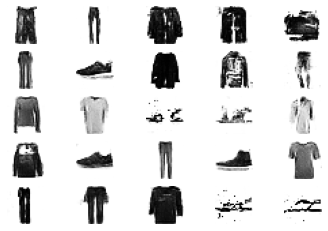

[INFO] starting epoch 3 of 50...
[INFO] Step 3_545: discriminator_loss=0.553155, adversarial_loss=1.053539


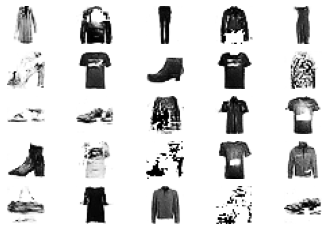

[INFO] starting epoch 4 of 50...
[INFO] Step 4_545: discriminator_loss=0.515971, adversarial_loss=0.937060


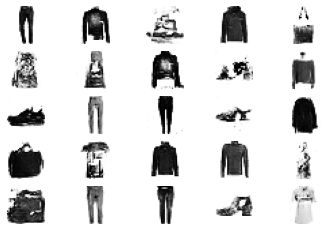

[INFO] starting epoch 5 of 50...
[INFO] Step 5_545: discriminator_loss=0.539562, adversarial_loss=1.143776


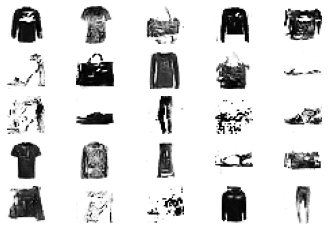

[INFO] starting epoch 6 of 50...
[INFO] Step 6_545: discriminator_loss=0.547021, adversarial_loss=0.912939


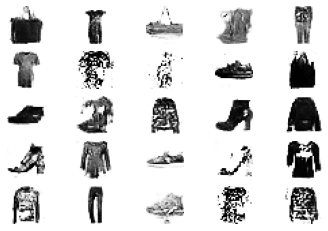

[INFO] starting epoch 7 of 50...
[INFO] Step 7_545: discriminator_loss=0.491930, adversarial_loss=0.912845


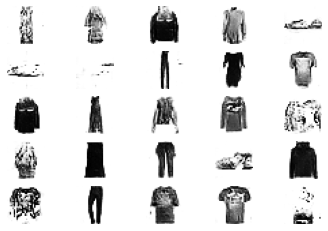

[INFO] starting epoch 8 of 50...
[INFO] Step 8_545: discriminator_loss=0.567036, adversarial_loss=1.097980


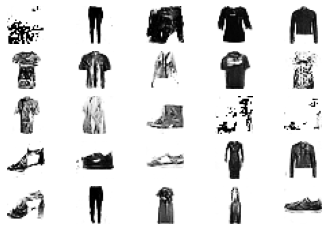

[INFO] starting epoch 9 of 50...
[INFO] Step 9_545: discriminator_loss=0.511158, adversarial_loss=0.895422


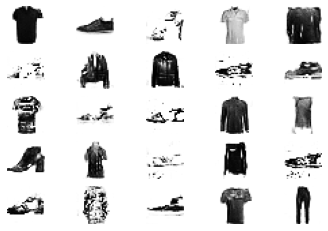

[INFO] starting epoch 10 of 50...
[INFO] Step 10_545: discriminator_loss=0.532065, adversarial_loss=1.189146


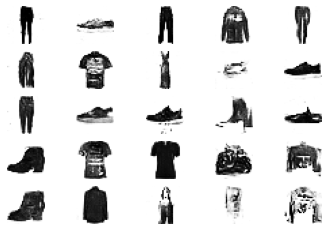

[INFO] starting epoch 11 of 50...
[INFO] Step 11_545: discriminator_loss=0.522191, adversarial_loss=0.962115


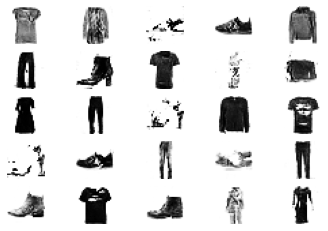

[INFO] starting epoch 12 of 50...
[INFO] Step 12_545: discriminator_loss=0.560188, adversarial_loss=1.233801


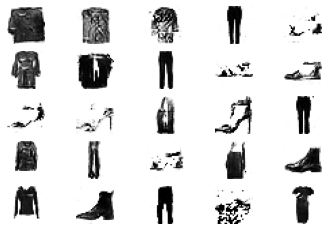

[INFO] starting epoch 13 of 50...
[INFO] Step 13_545: discriminator_loss=0.520934, adversarial_loss=1.075813


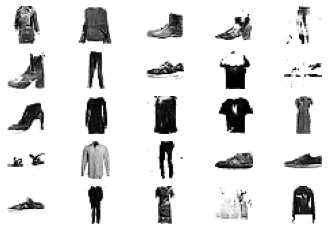

[INFO] starting epoch 14 of 50...
[INFO] Step 14_545: discriminator_loss=0.514304, adversarial_loss=1.118636


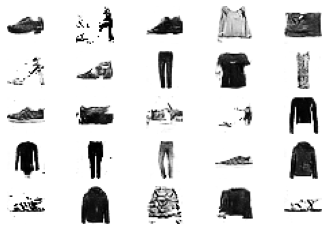

[INFO] starting epoch 15 of 50...
[INFO] Step 15_545: discriminator_loss=0.488486, adversarial_loss=1.260488


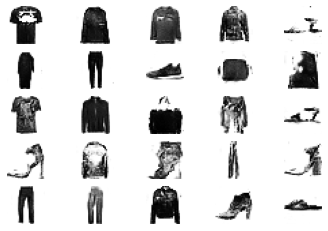

[INFO] starting epoch 16 of 50...
[INFO] Step 16_545: discriminator_loss=0.505894, adversarial_loss=1.055359


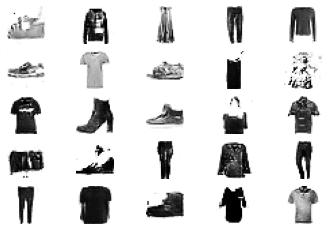

[INFO] starting epoch 17 of 50...
[INFO] Step 17_545: discriminator_loss=0.494791, adversarial_loss=1.334271


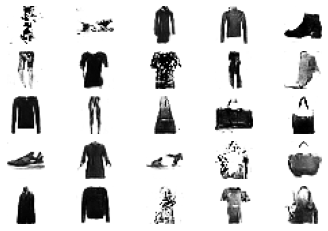

[INFO] starting epoch 18 of 50...
[INFO] Step 18_545: discriminator_loss=0.512902, adversarial_loss=1.162917


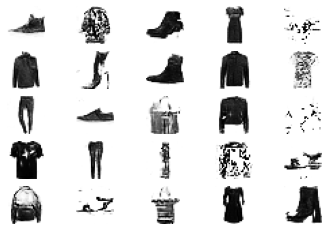

[INFO] starting epoch 19 of 50...
[INFO] Step 19_545: discriminator_loss=0.510294, adversarial_loss=1.365865


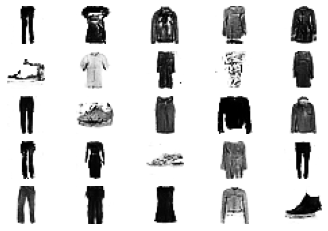

[INFO] starting epoch 20 of 50...
[INFO] Step 20_545: discriminator_loss=0.478705, adversarial_loss=1.226233


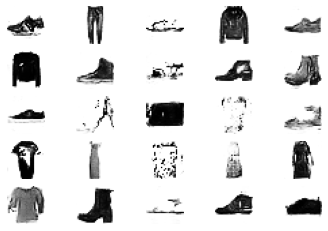

[INFO] starting epoch 21 of 50...
[INFO] Step 21_545: discriminator_loss=0.538940, adversarial_loss=0.900249


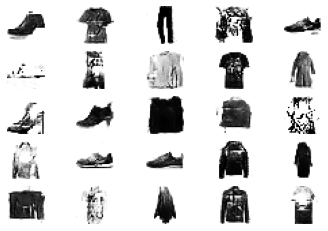

[INFO] starting epoch 22 of 50...
[INFO] Step 22_545: discriminator_loss=0.494159, adversarial_loss=1.263606


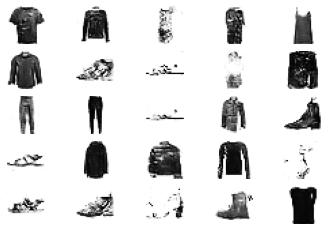

[INFO] starting epoch 23 of 50...
[INFO] Step 23_545: discriminator_loss=0.514866, adversarial_loss=1.277851


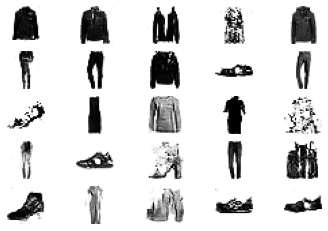

[INFO] starting epoch 24 of 50...
[INFO] Step 24_545: discriminator_loss=0.516248, adversarial_loss=1.172584


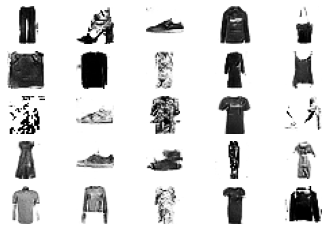

[INFO] starting epoch 25 of 50...
[INFO] Step 25_545: discriminator_loss=0.500811, adversarial_loss=1.295527


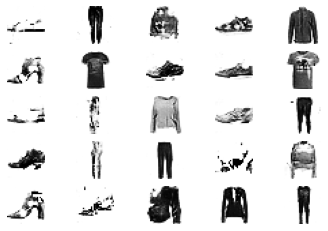

[INFO] starting epoch 26 of 50...
[INFO] Step 26_545: discriminator_loss=0.428300, adversarial_loss=1.270992


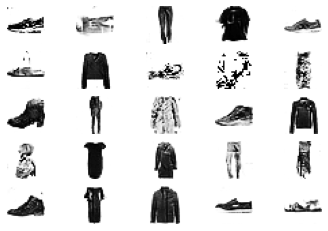

[INFO] starting epoch 27 of 50...
[INFO] Step 27_545: discriminator_loss=0.472035, adversarial_loss=1.183076


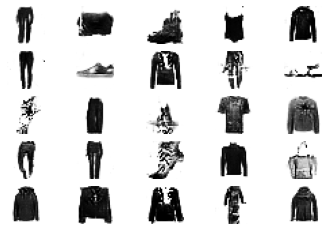

[INFO] starting epoch 28 of 50...
[INFO] Step 28_545: discriminator_loss=0.442919, adversarial_loss=1.141989


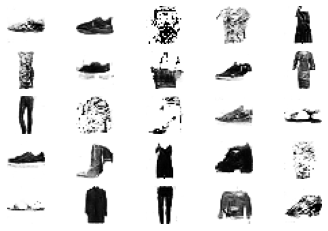

[INFO] starting epoch 29 of 50...
[INFO] Step 29_545: discriminator_loss=0.441616, adversarial_loss=1.315539


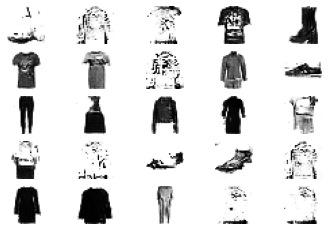

[INFO] starting epoch 30 of 50...
[INFO] Step 30_545: discriminator_loss=0.449224, adversarial_loss=1.504334


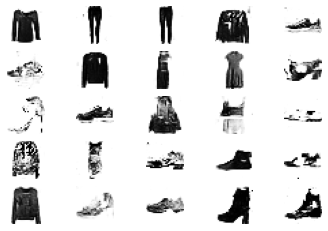

[INFO] starting epoch 31 of 50...
[INFO] Step 31_545: discriminator_loss=0.428759, adversarial_loss=1.232978


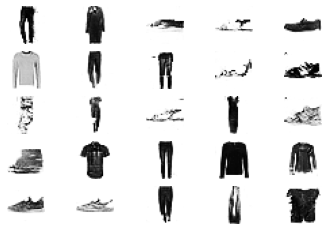

[INFO] starting epoch 32 of 50...
[INFO] Step 32_545: discriminator_loss=0.470548, adversarial_loss=1.173477


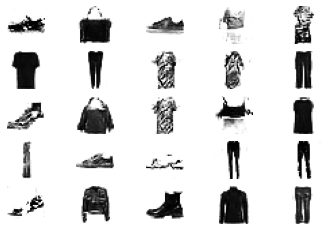

[INFO] starting epoch 33 of 50...
[INFO] Step 33_545: discriminator_loss=0.475487, adversarial_loss=1.300950


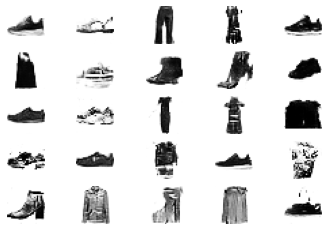

[INFO] starting epoch 34 of 50...
[INFO] Step 34_545: discriminator_loss=0.467453, adversarial_loss=1.427112


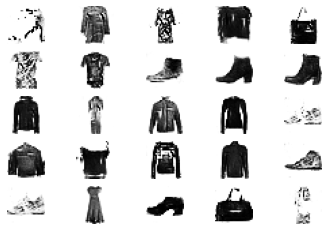

[INFO] starting epoch 35 of 50...
[INFO] Step 35_545: discriminator_loss=0.433379, adversarial_loss=1.282727


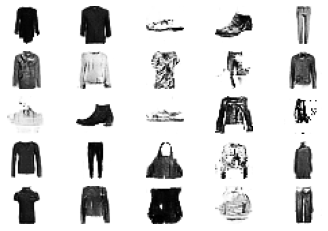

[INFO] starting epoch 36 of 50...
[INFO] Step 36_545: discriminator_loss=0.442361, adversarial_loss=1.432092


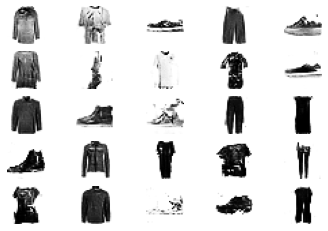

[INFO] starting epoch 37 of 50...
[INFO] Step 37_545: discriminator_loss=0.442046, adversarial_loss=1.364575


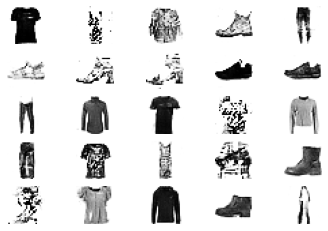

[INFO] starting epoch 38 of 50...
[INFO] Step 38_545: discriminator_loss=0.448912, adversarial_loss=1.491989


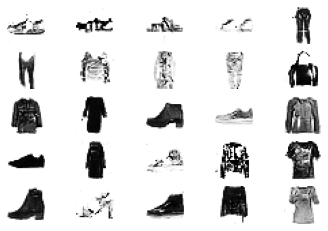

[INFO] starting epoch 39 of 50...
[INFO] Step 39_545: discriminator_loss=0.448365, adversarial_loss=1.393958


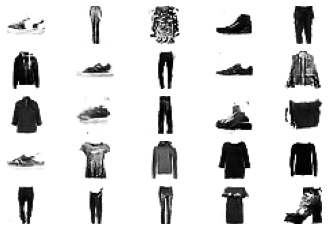

[INFO] starting epoch 40 of 50...
[INFO] Step 40_545: discriminator_loss=0.426437, adversarial_loss=1.518245


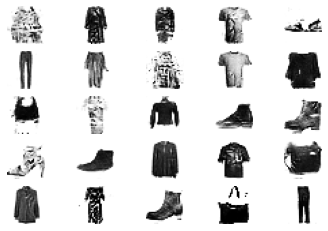

[INFO] starting epoch 41 of 50...
[INFO] Step 41_545: discriminator_loss=0.395852, adversarial_loss=1.483231


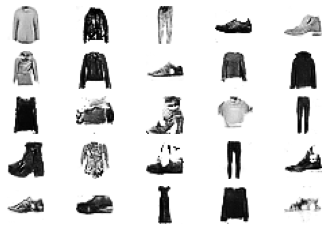

[INFO] starting epoch 42 of 50...
[INFO] Step 42_545: discriminator_loss=0.410548, adversarial_loss=1.463581


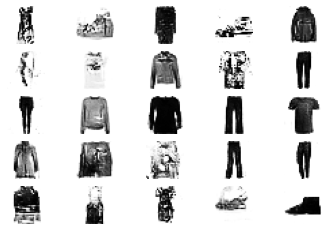

[INFO] starting epoch 43 of 50...
[INFO] Step 43_545: discriminator_loss=0.443335, adversarial_loss=1.514750


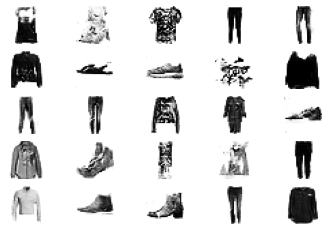

[INFO] starting epoch 44 of 50...
[INFO] Step 44_545: discriminator_loss=0.446908, adversarial_loss=1.582656


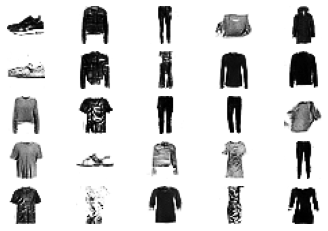

[INFO] starting epoch 45 of 50...
[INFO] Step 45_545: discriminator_loss=0.406513, adversarial_loss=1.469280


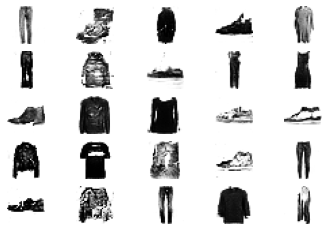

[INFO] starting epoch 46 of 50...
[INFO] Step 46_545: discriminator_loss=0.396742, adversarial_loss=1.419822


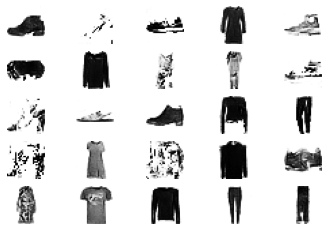

[INFO] starting epoch 47 of 50...
[INFO] Step 47_545: discriminator_loss=0.440039, adversarial_loss=1.634961


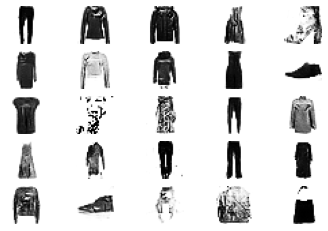

[INFO] starting epoch 48 of 50...
[INFO] Step 48_545: discriminator_loss=0.420750, adversarial_loss=1.567308


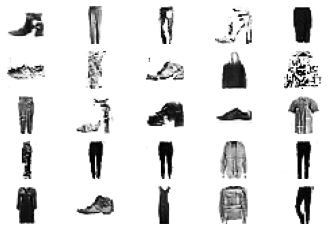

[INFO] starting epoch 49 of 50...
[INFO] Step 49_545: discriminator_loss=0.422147, adversarial_loss=1.511431


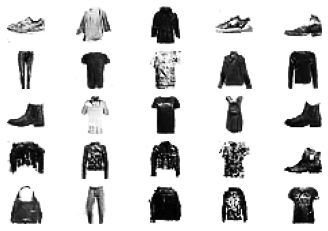

[INFO] starting epoch 50 of 50...
[INFO] Step 50_545: discriminator_loss=0.437032, adversarial_loss=1.408359


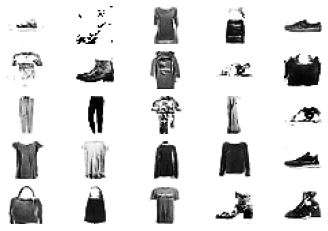

In [ ]:
# randomly generate some benchmark noise so we can consistently
# visualize how the generative modeling is learning
print("[INFO] starting training...")
benchmarkNoise = np.random.uniform(-1, 1, size=(256, 100))
# loop over the epochs
for epoch in range(0, NUM_EPOCHS):
  # show epoch information and compute the number of batches per
  # epoch
  print("[INFO] starting epoch {} of {}...".format(epoch + 1,
    NUM_EPOCHS))
  batchesPerEpoch = int(trainImages.shape[0] / BATCH_SIZE)
  # loop over the batches
  for i in range(0, batchesPerEpoch):
    # initialize an (empty) output path
    p = None
    # select the next batch of images, then randomly generate
    # noise for the generator to predict on
    imageBatch = trainImages[i * BATCH_SIZE:(i + 1) * BATCH_SIZE]
    noise = np.random.uniform(-1, 1, size=(BATCH_SIZE, 100))

    # generate images using the noise + generator model
    genImages = generator.predict(noise, verbose=0)
    # concatenate the *actual* images and the *generated* images,
    # construct class labels for the discriminator, and shuffle
    # the data
    X = np.concatenate((imageBatch, genImages))
    y = ([1] * BATCH_SIZE) + ([0] * BATCH_SIZE)
    y = np.reshape(y, (-1,))
    (X, y) = shuffle(X, y)
    # train the discriminator on the data
    discLoss = discriminator.train_on_batch(X, y)

    # let's now train our generator via the adversarial model by
    # (1) generating random noise and (2) training the generator
    # with the discriminator weights frozen
    noise = np.random.uniform(-1, 1, (BATCH_SIZE, 100))
    fakeLabels = [1] * BATCH_SIZE
    fakeLabels = np.reshape(fakeLabels, (-1,))
    ganLoss = gan.train_on_batch(noise, fakeLabels)

    # check to see if this is the end of an epoch, and if so,
    # initialize the output path
    if i == batchesPerEpoch - 1:
      print("[INFO] Step {}_{}: discriminator_loss={:.6f}, "
      "adversarial_loss={:.6f}".format(epoch + 1, i,
      discLoss, ganLoss))
      # size of the latent space
      latent_dim = 100

      # generate samples
      n_samples = 25
      X, _ = generate_fake_samples(generator, latent_dim, n_samples)
      # plot the generated samples
      for i in range(n_samples):
        # define subplot
        pyplot.subplot(5, 5, 1 + i)
        # turn off axis labels
        pyplot.axis('off')
        # plot single image
        pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
      # show the figure
      pyplot.show()

# Adding Conditional Generation functionality to our GAN architecture

The GAN architecture that we created above is an example of unconditional Generations i.e. the entire architecture is generated without passing any information related to the class labels.

As you might have noticed above we haven't used any labels while training either the discriminator or the generator.

With unconditional Generation we get output from random classes, on the other hand **conditional generation** allows us to ask for an example from a specific class and you get what you ask for, i.e. a random example from a class you specify.



## Genrator Input 

In conditional GANs, the input vector for the generator will need to include the class information. The class is represented using a one-hot encoded vector where its length is the number of classes and each index represents a class. The vector is all 0's and a 1 on the chosen class.
We'll combine/concatenate this one-hot vector with the random noise to create a new vector to be passed into the generator network.

In [2]:
def get_one_hot_labels(labels, n_classes):
    return one_hot(labels, n_classes)

Next, we need to be able to concatenate the one-hot class vector to the noise vector before giving it to the generator. We will also need to do this when adding the class channels to the discriminator.


In [3]:
def combine_vectors(x, y):

    combined = torch.cat((x.float(),y.float()),1)
    
    return combined

In [ ]:
fmnist_shape = (1, 28, 28)
n_classes = 10

#initializing a few hyper-parameters
NUM_EPOCHS = 50
BATCH_SIZE = 128
INIT_LR = 2e-4

In [4]:
# load the Fashion MNIST dataset and stack the training and testing
# data points so we have additional training data

((trainX, _), (testX, _)) = fashion_mnist.load_data()
trainImages = np.concatenate([trainX, testX])
# add in an extra dimension for the channel and scale the images
# into the range [-1, 1] (which is the range of the tanh
# function)
trainImages = np.expand_dims(trainImages, axis=-1)
trainImages = (trainImages.astype("float") - 127.5) / 127.5

4423680/4422102 [==============================] - 0s 0us/step
